# Solar evolution models with a central black hole

### HRDs for various tracks

[Earl Patrick Bellinger](https://earlbellinger.com)$^{1,2,3}$

$^1$_Max Planck Institute for Astrophysics, Garching, Germany_ \
$^2$_Stellar Astrophysics Centre, Aarhus, Denmark_ \
$^3$_Yale University, New Haven, CT_

In [1]:
import os

import numpy as np
import pandas as pd
import scipy as sp

import matplotlib as mpl
import matplotlib.pyplot as plt

from scipy import integrate
from scipy.optimize import minimize
from scipy.interpolate import interp1d

from astropy import constants as cnt
from astropy import units as unt

import dask.dataframe as dd
import dask.array as da

from uncertainties import ufloat, unumpy

from joblib import Parallel, delayed

from tqdm.notebook import tqdm

from ipywidgets import interact, FloatSlider, IntSlider

#import tomso
#import tomso.gyre as gyre
#import tomso.fgong as fgong
#import mistery

In [2]:
import seaborn as sns
sns.set(style="ticks", palette="muted", rc={"xtick.bottom" : True, "ytick.left" : True})
plt.style.use('figs/thinfig')
red = "#CA0020"
orange = "#F97100" 
blue = "#0571b0"

In [3]:
# labels 
density     = r'density $\mathbf{\rho~/~[g/cm^3]}$'
frac_radius = r'fractional radius $\mathbf{r/R_\odot}$'
frac_mass   = r'fractional mass $\mathbf{m/M_\odot}$'
Teff        = r'effective temperature $\mathbf{T_{eff}/K}$'
luminosity  = r'luminosity $\mathbf{L/L_\odot}$'

In [26]:
dfs = [pd.read_table('sep_pbh_grid/normal/LOGS/history.data', skiprows=5, sep='\s+'),
       pd.read_table('sep_pbh_grid/grid/M=1_MBHf=-11/LOGS/history.data', skiprows=5, sep='\s+'),
       pd.read_table('sep_pbh_grid/grid/M=1_MBHf=-10/LOGS/history.data', skiprows=5, sep='\s+'),
       pd.read_table('sep_pbh_grid/grid/M=1_MBHf=-12/LOGS/history.data', skiprows=5, sep='\s+'),
       pd.read_table('sep_pbh_grid/grid/M=1_MBHf=-4/LOGS/history.data', skiprows=5, sep='\s+')]#,
       #pd.read_table('sep_pbh_grid/grid/M=1_MBHf=-13_Z=0.02/LOGS/history.data', skiprows=5, sep='\s+')]

In [27]:
types = ['X', 'O', 'B', 'A', 'F', 'G', 'K', 'M']
spectrals = np.array([1e99, 30000, 10000, 7500, 6000, 5200, 3700, 2400])
rgbs = [(1, 1, 1), # X, temp class just for setting upper bound 
        (175/255, 201/255, 1),       # O
        (199/255, 216/255, 1),       # B
        (1,       244/255, 243/255), # A 
        (1,       229/255, 207/255), # F 
        (0.95,0.95,0.95),
        (1,1,1),
        #(1,       217/255, 178/255), # G 
        #(1,       199/255, 142/255), # K 
        (1,       166/255, 81/255)]  # M

def add_spectral_background(ax):
    last = 1e6
    for spectral, rgb in zip(spectrals, rgbs):
        if spectral < 10000 and spectral > 3700:
            plt.fill_between([last, spectral], 1e-1, 1e3, color=rgb, zorder=-99999999)
        last = spectral
    top = ax.twiny()
    top.set_xlabel(r'spectral type', labelpad=10)
    
    xmax, xmin = np.array(ax.get_xlim())
    types_ = [] 
    spectrals_ = [] 
    for i in range(len(spectrals)):
        if spectrals[i] >= xmax: 
            if i+1 <= len(spectrals) and spectrals[i+1] < xmax:
                spectrals_ += [xmax]
                types_ += [types[i]]
        elif spectrals[i] <= xmin: 
            spectrals_ += [xmin]
            types_ += [types[i]]
            break
        else:
            spectrals_ += [spectrals[i]]
            types_ += [types[i]]
    
    top.set_xticks([], minor=True)
    top.set_xticks([ (spectrals_[k]+spectrals_[k+1])/2 
                     for k in range(len(spectrals_)-1) ])
    top.set_xticklabels(types_[1:]) 
    top.set_xlim(ax.get_xlim())

def add_radius_lines(Rs=[10, 100], Tlower=1, Tupper=1e6, Lpos=0, 
                     sigma=5.67e-5, Lsol=3.828e33, Rsol=6.957e10):
    L_ = lambda R, Teff: 4*np.pi*(R*Rsol)**2*sigma*Teff**4 / Lsol
    T_ = lambda R, L: np.power(L*Lsol/(4*np.pi*(R*Rsol)**2*sigma), 1/4)
    #print(T_(1,1))
    for R in Rs:
        #plt.text(T_(R, Lpos) + 0.04, Lpos, 
        #         str(R)+r' R$_\odot$', c='k', size=16, weight='bold', rotation=-63)
        plt.plot([Tlower,        Tupper], 
                 [L_(R, Tlower), L_(R, Tupper)], 
                 ls='--', c='lightgray', lw=2, zorder=-9999999)

## HR diagrams

/tmp/ipykernel_1026/1564644155.py:109: UserWarning: AutoMinorLocator does not work with logarithmic scale
  plt.tight_layout()
/tmp/ipykernel_1026/1564644155.py:110: UserWarning: AutoMinorLocator does not work with logarithmic scale
  plt.savefig('figs/hr-bhsun.pdf')
/tmp/ipykernel_1026/1564644155.py:110: UserWarning: AutoMinorLocator does not work with logarithmic scale
  plt.savefig('figs/hr-bhsun.pdf')
/afs/mpa/data/earl/anaconda3/anaconda3/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: AutoMinorLocator does not work with logarithmic scale
  fig.canvas.print_figure(bytes_io, **kw)


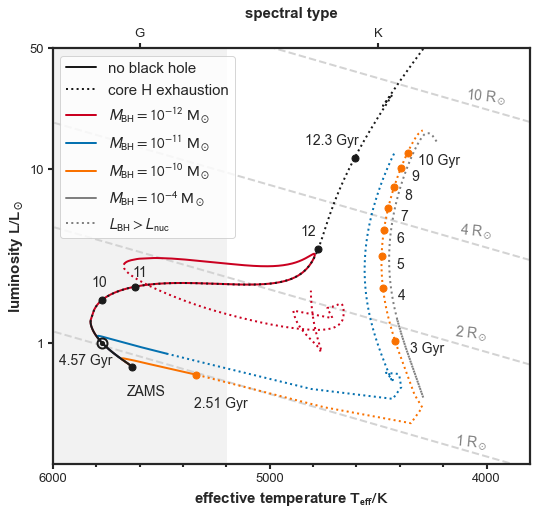

In [28]:
plt.figure(figsize=(4*(3)*0.65, 5*(1.5)))

df = dfs[0].copy() # no black hole
rgcond = np.logical_and(df.star_age > 1e9, df.center_h1 < 0.1)
ms = df[np.logical_and(df.center_h1 < df.center_h1.values[0]*.99, ~(rgcond))]
rg = df[rgcond]
ms = pd.concat([ms, rg.iloc[0:1]], ignore_index=True)
plt.plot(10**ms['log_Teff'], 10**ms['log_L'], lw=2, c='k', zorder=-9, label=r'no black hole')
plt.plot(10**rg['log_Teff'], 10**rg['log_L'], lw=2, c='k', zorder=-9, ls=':', label='core H exhaustion')
plt.plot(10**ms['log_Teff'].values[0], 10**ms['log_L'].values[0], 'ko', zorder=-9, ms=7)

df = dfs[3].copy() # 10^-12
df = df[df.star_age < df.star_age.values[-1]*.99]
rgcond = df.L_BH > 10**df.log_LH
ms = df[np.logical_and(df.star_age > df.star_age[(df.center_h1 < df.center_h1.values[0]*.99)].min(), ~rgcond)]
rg = df[rgcond]
ms = pd.concat([ms, rg.iloc[0:1]], ignore_index=True)
plt.plot(10**ms['log_Teff'], 10**ms['log_L'], lw=2, c=red, zorder=-99, label=r'$M_{\rm{BH}} = 10^{-12}~\rm{M}_\odot$')
plt.plot(10**rg['log_Teff'], 10**rg['log_L'], lw=2, c=red, zorder=-99, ls=':')

df = dfs[1].copy() # 10^-11
df = df[df.star_age < df.star_age.values[-1]*.99]
rgcond = df.L_BH >= 10**df.log_LH
ms = df[np.logical_and(df.star_age > df.star_age[(df.center_h1 < df.center_h1.values[0]*.99)].min(), ~rgcond)]
rg = df[rgcond]
ms = pd.concat([ms, rg.iloc[0:1]], ignore_index=True)
plt.plot(10**ms['log_Teff'], 10**ms['log_L'], lw=2, c=blue, zorder=-99, label=r'$M_{\rm{BH}} = 10^{-11}~\rm{M}_\odot$')
plt.plot(10**rg['log_Teff'], 10**rg['log_L'], lw=2, c=blue, zorder=-99, ls=':')

df = dfs[2].copy() # 10^-10
df = df[df.star_age < df.star_age.values[-1]*.99]
rgcond = df.L_BH > 10**df.log_LH
ms = df[np.logical_and(df.star_age > df.star_age[(df.center_h1 < df.center_h1.values[0]*.99)].min(), ~rgcond)]
rg = df[rgcond]
ms = pd.concat([ms, rg.iloc[0:1]], ignore_index=True)
plt.plot(10**ms['log_Teff'], 10**ms['log_L'], lw=2, c=orange, zorder=-10, label=r'$M_{\rm{BH}} = 10^{-10}~\rm{M}_\odot$')
plt.plot(10**rg['log_Teff'], 10**rg['log_L'], lw=2, c=orange, zorder=-10, ls=':')

df = dfs[4].copy() # 10^4
df = df[df.star_age < df.star_age.values[-1]*.99]
rgcond = df.L_BH > 10**df.log_LH
ms = df[np.logical_and(df.star_age > df.star_age[(df.center_h1 < df.center_h1.values[0]*.99)].min(), ~rgcond)]
rg = df[rgcond]
ms = pd.concat([ms, rg.iloc[0:1]], ignore_index=True)
plt.plot(10**ms['log_Teff'], 10**ms['log_L'], lw=2, c='gray', zorder=-999, label=r'$M_{\rm{BH}} = 10^{-4}~\rm{M}_\odot$')
plt.plot(10**rg['log_Teff'], 10**rg['log_L'], lw=2, c='gray', zorder=-999, ls=':', label=r'$L_{\rm{BH}}>L_{\rm{nuc}}$')


plt.text(4150, 0.26*.95, r'1 R$_\odot$', c='gray', size=14, rotation=-6, ha='left', zorder=100)
plt.text(4150, 1.1*.95, r'2 R$_\odot$', c='gray', size=14, rotation=-6, ha='left', zorder=100)
plt.text(4125, 4.4*0.98*.95, r'4 R$_\odot$', c='gray', size=14, rotation=-6, ha='left', zorder=100)
plt.text(4100, 26.6*0.95*.95, r'10 R$_\odot$', c='gray', size=14, rotation=-6, ha='left', zorder=100)
#plt.text(4050, 95*.95, r'20 R$_\odot$', c='gray', size=14, rotation=-6, ha='left', zorder=100)

#for ii in range(1,3):
df = dfs[2]
Teff_func = interp1d(df['star_age']/1e9, 10**df['log_Teff'])
L_func    = interp1d(df['star_age']/1e9, 10**df['log_L'])
ages = [3, 4, 5, 6, 7, 8, 9, 10]
for age in ages:
    Teff_ = Teff_func(age)
    L_ = L_func(age)
    plt.plot(Teff_, L_, 'o', c=orange, zorder=99, ms=7)
    if age > 2: #age < 10 and age > 2 and age not in [7, 8]:
        plt.text(0.995*Teff_ - 25 + (-20 if age < 6 else -10 if age < 8 else 0), L_*0.85, 
                 str(age) + (' Gyr' if age == 3 or age == 10 else ''), ha='left', size=14, zorder=9999999)

first = 2.51
Teff_ = Teff_func(first)
L_ = L_func(first)
plt.plot(Teff_, L_, 'o', c=orange, zorder=99, ms=7)
plt.text(0.995*Teff_ + 35, L_*0.65, str(first) + ' Gyr', ha='left', size=14, zorder=9999999)


df = dfs[0]
Teff_func = interp1d(df['star_age']/1e9, 10**df['log_Teff'])
L_func    = interp1d(df['star_age']/1e9, 10**df['log_L'])
ages = [10, 11, 12, 12.3]
for age in ages:
    Teff_ = Teff_func(age)
    L_ = L_func(age)
    plt.plot(Teff_, L_, 'ko', zorder=99, ms=7)
    if age >2:
        plt.text(Teff_ +50 + (-40 if age == 11 else 0) + (30 if age>11 else 0) + (150 if age>12 else 0), 
                 L_*1.15 if age == 11 else L_*1.2 if age != 3 else L_, 
                 str(age) + (' Gyr' if age == 12.3 else ''), ha='left', size=14, zorder=9999999)


plt.xlim([6000, 3800])
plt.ylim([2e-1, 50])
plt.xlabel(Teff)
plt.ylabel(luminosity)
plt.semilogy()

plt.legend(loc='upper left')

plt.gca().set_xticks([4000, 5000, 6000])
plt.gca().set_yticks([1, 10, 50])
plt.gca().set_yticklabels(['1', '10', '50'])

plt.plot(5772, 1, c='k', marker='o', mew=2, mfc='#ffffff00', mec='k', zorder=99999, ms=10)
plt.plot(5772, 1, c='k', marker='.', zorder=99999, ms=8)
plt.text(5970, 0.75, '4.57 Gyr', size=14, zorder=9999999)
plt.text(5660, 0.5, 'ZAMS', size=14, zorder=9999999)

add_radius_lines([1, 2, 4, 10], Tupper=6000, Tlower=3800)
add_spectral_background(plt.gca())

plt.tight_layout()
plt.savefig('figs/hr-bhsun.pdf')
plt.show()

[]

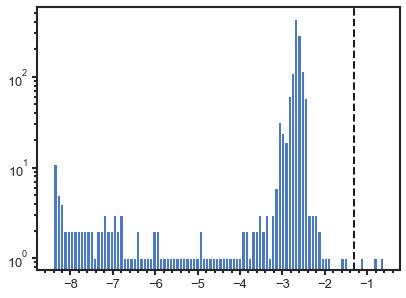

In [11]:
diffs = np.abs(np.diff(dfs[2].log_L))
plt.hist(np.log10(diffs), bins=100)
plt.axvline(np.log10(0.05), ls='--', c='k')
plt.semilogy()

In [25]:
df = dfs[1]

R_sun = 10**df.log_R.values[-1] * 6.96e10  # Sun's radius in cm
T_sun = 10**df.log_Teff.values[-1] #5772  # Sun's temperature in K
a_0 = 1.496e13  # Average distance from Earth to Sun in cm

# Calculate Earth's blackbody temperature
T_earth_4th = (R_sun ** 2 * T_sun ** 4) / (4 * a_0 ** 2)
T_earth = np.sqrt(np.sqrt(T_earth_4th))
print(10**df.log_L.values[-1], 'Lsun')
print(R_sun/6.96e10, 'Rsun')
print(R_sun/a_0, 'au')
print(T_earth, 'Kelvin')
print(T_earth - 273.15, 'celsius')

13.26158790976757 Lsun
6.230445002933967 Rsun
0.028986562313115246 au
531.2504216728878 Kelvin
258.1004216728878 celsius
